https://www.kaggle.com/datasets/vladtasca/fomc-meeting-statements-and-minutes/code

# Exploration Notebook for FOMC Meeting Statements & Minutes
The goal of this notebook is to give a quick overview of the FOMC Meeting Statements & Minutes dataset and lay out a few possibly interesting avenues of research.

The FOMC meeting statement document is one of the main formal communication documents used by the Fed, and contains information about key interest rate decisions, an assessment of the economic outlook, a view on inflation as well as forward guidance. This information helps businesses, investors and the general public take monetary policy into account and make more informed economic decisions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

comms = pd.read_csv('/Users/Xavier/Downloads/communications.csv')

# Split into statements and minutes
statements = comms.loc[comms['Type'] == 'Statement'].copy()
minutes = comms.loc[comms['Type'] == 'Minute'].copy()

statements = (statements
 .assign(Date = lambda df: pd.to_datetime(df['Date']))
 .set_index('Date')
)

## Statements verbosity
An interesting first aspect to dig into is how long (verbose) the statements are, and their evolution over time.

<Axes: xlabel='Date'>

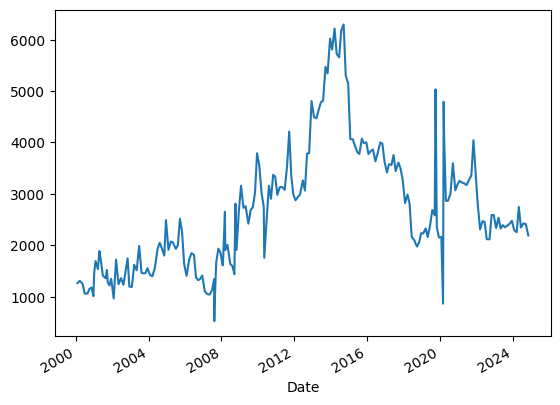

In [2]:
statements['Text Length'] = statements['Text'].str.len()
statements['Text Length'].plot()

There is a lot of variability in the average length of an FOMC statement, but overall the trend seems to be towards longer documents.
For illustrative purposes, the longest and shortest statements are included below:

In [3]:
# Longest FOMC statement in the dataset
print(statements.loc[statements['Text Length'].idxmax(), 'Text'])

Information received since the Federal Open Market Committee met in July suggests that economic activity is expanding at a moderate pace. On balance, labor market conditions improved somewhat further; however, the unemployment rate is little changed and a range of labor market indicators suggests that there remains significant underutilization of labor resources. Household spending appears to be rising moderately and business fixed investment is advancing, while the recovery in the housing sector remains slow. Fiscal policy is restraining economic growth, although the extent of restraint is diminishing. Inflation has been running below the Committee's longer-run objective. Longer-term inflation expectations have remained stable.
    
    
       Consistent with its statutory mandate, the Committee seeks to foster maximum employment and price stability. The Committee expects that, with appropriate policy accommodation, economic activity will expand at a moderate pace, with labor market 

In [4]:
# Shortest FOMC statement in the dataset
print(statements.loc[statements['Text Length'].idxmin(), 'Text'])

The Federal Reserve is providing liquidity to facilitate the orderly functioning of financial markets.
The Federal Reserve will provide reserves as necessary through open market operations to promote trading in the federal funds market at rates close to the Federal Open Market Committee's target rate of 5-1/4 percent. In current circumstances, depository institutions may experience unusual funding needs because of dislocations in money and credit markets. As always, the discount window is available as a source of funding.


## External data
Bringing in outside data allows us to try to answer more interesting questions. 

### Effective Federal Funds Rate
For instance, let's import a time series of the effective federal funds rate. Fortunately, this dataset is updated daily so stale data won't be an issue.

<Axes: xlabel='Date'>

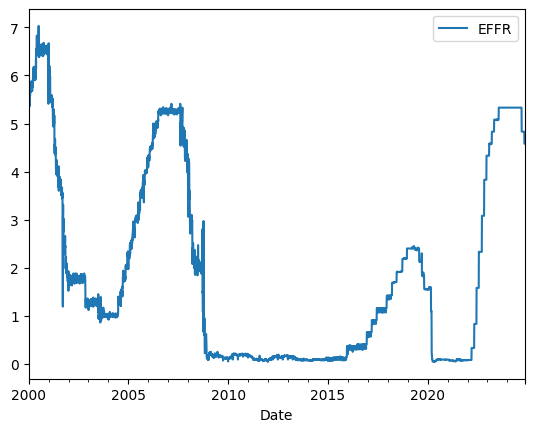

In [5]:
# Load in effective federal funds rate series
# Taken from https://www.kaggle.com/datasets/natashk/effective-federal-funds-rate
effr = pd.read_csv('FRB_H15.csv')

effr = (effr
 .assign(Date = lambda df: pd.to_datetime(df['Time Period']))
 .rename(columns={'RIFSPFF_N.D': 'EFFR'})
 .set_index('Date')
 [['EFFR']]
)

effr['2000':].plot()

Some regime changes are clearly observable in the graph above, including the shift to near-zero rates after the 2008 global financial crisis and the increase that kicked off in 2022 and remains ongoing at the time of publishing this notebook.

---
Armed with these dataseries, let's explore an interesting relationship - does the Fed communicate more when they take action by raising or lowering the effective funding rate?

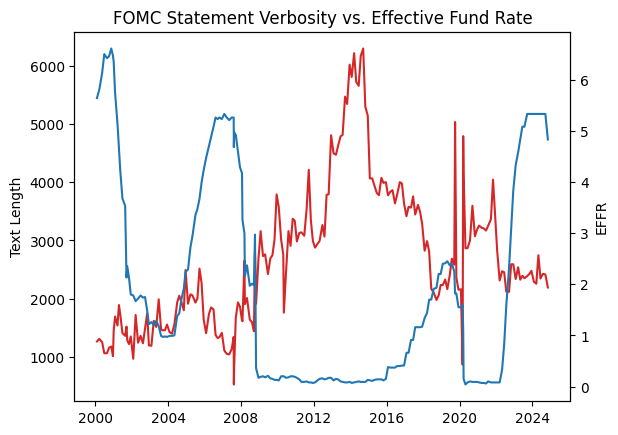

In [6]:
merged = statements.merge(effr, left_index=True, right_index=True)[['Text Length', 'EFFR']]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Text Length')
ax1.plot(merged.index, merged['Text Length'], color=color)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('EFFR')
ax2.plot(merged.index, merged['EFFR'], color=color)
ax2.tick_params(axis='y')

plt.title('FOMC Statement Verbosity vs. Effective Fund Rate')
plt.show()

Off the bat, it looks like the initial expectation could be wrong - in fact the Fed appears to communicate less when making significant changes to the funding rate! The correlation between the series seems to reinforce what is visible in the graph:

In [7]:
merged['Text Length'].corr(merged['EFFR'])

-0.6244161018203873

### Ending note
A simple plot and correlation between the series is, of course, not enough to draw meaningful conclusions regarding the relationships discussed. However, it does represent a first step towards showing what's possible when combining the FOMC Meeting statements & minutes dataset with external data.